## Prep

In [32]:
# Import packages
import pandas as pd
import plotly.graph_objects as go
import networkx as nx
from ds_common_utils.aux.io.snowflake_tools import SnowflakeTools
from math import log
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt
import community.community_louvain as community_louvain
import numpy as np

In [33]:
# Get connection
con = SnowflakeTools().get_snowflake_ctx(
     method = 'token',
    user = '250807',
    role = 'INSIGHT_ANALYST_MERCH_DE_GENERAL_PRD',
    warehouse = 'INSIGHT_ANALYST_WH'
)
with open('sql/item_association.sql', 'r') as query:
        df = pd.read_sql_query(query.read(), con)

snowflake_tools - 2025-06-24 16:56:15.986769+10:00 - Generating new token with 'INSIGHT_ANALYST_MERCH_DE_GENERAL_PRD' role and 'SESSION:ROLE-ANY' scope...
snowflake_tools - 2025-06-24 16:56:22.997054+10:00 - Saved token with '2025-06-24 20:56:22+10:00' expiry...


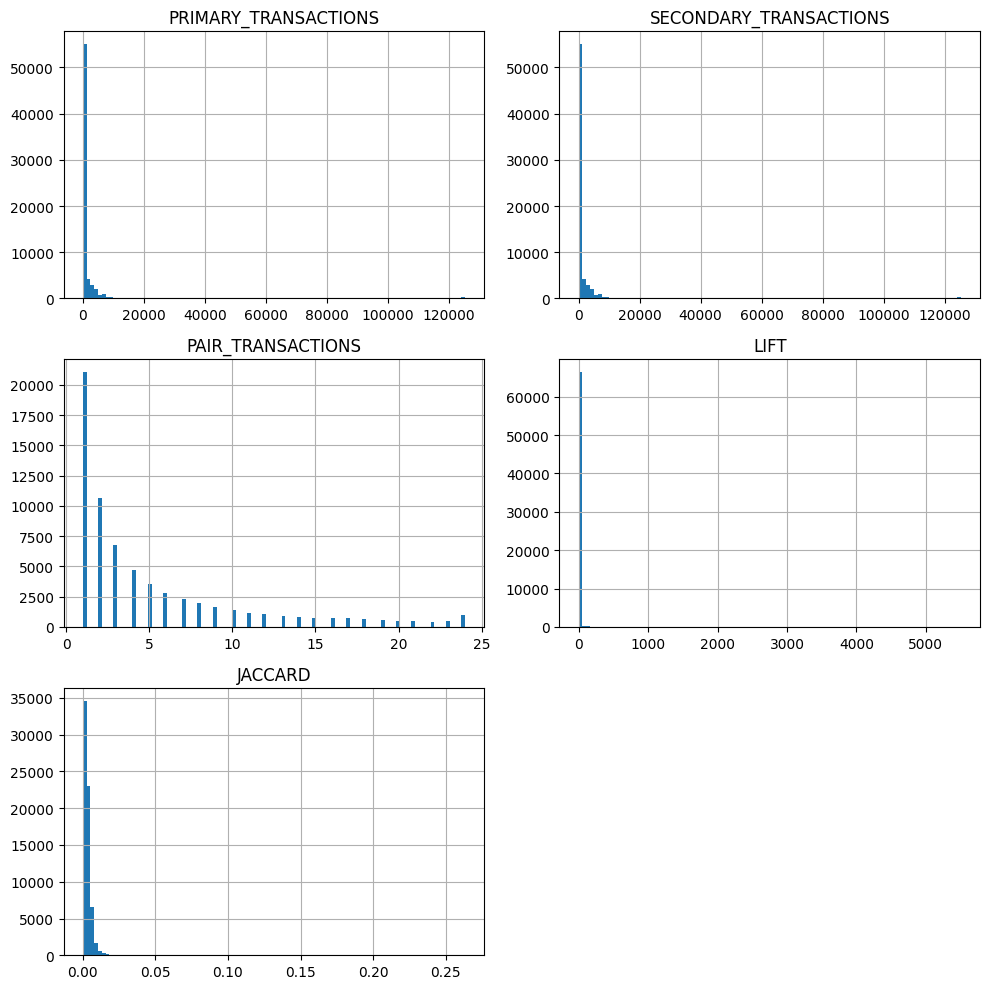

In [34]:
# Plot histograms of numerical columns
numeric_cols = df.select_dtypes(include='number').columns
df[numeric_cols].hist(bins=100, figsize=(10, 10), layout=(3, 2))
plt.tight_layout()
plt.show()

## Parameter Tuning

In [122]:
TRX_THRESHOLD = 10 # Min N frequent pairs
QUANTILE = 0.999 # Nth percentile of metric similarity
TOP_N = 5 # top-N associated item classes per primary class
RESO = 1 # >1.0 → more, smaller communities
METRIC = 'LIFT' # LIFT or JACCARD

## Working

In [123]:
filtered_df = df[(df['PRIMARY_ID'] != '400 RODENT PEST CONTROL' ) & ( df['SECONDARY_ID']!='400 RODENT PEST CONTROL')]

filtered_df = filtered_df[filtered_df['PAIR_TRANSACTIONS'] >= TRX_THRESHOLD]
threshold = filtered_df[METRIC].quantile(QUANTILE)
filtered_df = filtered_df[filtered_df[METRIC] >= threshold]
top_edges = filtered_df.sort_values(METRIC, ascending=False).groupby('PRIMARY_ID').head(TOP_N)


In [124]:
filtered_df.sort_values(by='PAIR_TRANSACTIONS', ascending=False)

,PRIMARY_ID,SECONDARY_ID,PRIMARY_TRANSACTIONS,SECONDARY_TRANSACTIONS,TRX_START_MONTH,TRX_END_MONTH,PAIR_TRANSACTIONS,LIFT,JACCARD
46376,401 FLOORING ADHESIVE,401 TOOLS AND ACCESSORIES,109,105,2024-07-01,2025-06-01,17,184.470424,0.086294
57414,401 TOOLS AND ACCESSORIES,401 FLOORING ADHESIVE,105,109,2024-07-01,2025-06-01,17,184.777894,0.086294
65839,403 CURTAINS,403 DRAPERY FITTINGS,91,354,2024-07-01,2025-06-01,17,65.564568,0.039720
66057,403 DRAPERY FITTINGS,403 CURTAINS,354,91,2024-07-01,2025-06-01,17,66.216831,0.039720
15773,400 GROUT AND SEALER,401 TOOLS AND ACCESSORIES,129,105,2024-08-01,2025-06-01,12,109.299668,0.054054
24399,400 NZ COLD FOOD SWEET,400 NZ HOT DRINKS,25,43,2024-07-01,2025-06-01,12,1020.000000,0.214286
24430,400 NZ HOT DRINKS,400 NZ COLD FOOD SWEET,43,25,2024-07-01,2025-06-01,12,1226.400000,0.214286
57334,401 TOOLS AND ACCESSORIES,400 GROUT AND SEALER,105,129,2024-08-01,2025-06-01,12,110.209524,0.054054
8311,400 DECKING TIMBER,400 LANDSCAPING TIMBER,127,249,2024-08-01,2025-06-01,11,43.646934,0.030137
20825,400 LANDSCAPING TIMBER,400 DECKING TIMBER,249,127,2024-08-01,2025-06-01,11,43.646934,0.030137


In [125]:
mode='lines',
line_shape='spline'
    
# Build node size map from your DataFrame
node_size_map = dict(zip(top_edges['PRIMARY_ID'], top_edges['PRIMARY_TRANSACTIONS']))

# Convert values to NumPy array
sizes = np.array(list(node_size_map.values()))

# Use np.ptp instead of .ptp()
norm_sizes = (sizes - sizes.min()) / np.ptp(sizes)  # scale to 0–1
scaled_sizes = 10 + norm_sizes * 30                 # scale to 10–40

# Final size map: Product ID → Scaled Size
scaled_size_map = dict(zip(node_size_map.keys(), scaled_sizes))

# Step 1: Build the full graph
G = nx.Graph()
for _, row in top_edges.iterrows():
    G.add_edge(row['PRIMARY_ID'], row['SECONDARY_ID'], weight=row[METRIC])

# Step 2: Louvain community detection
partition = community_louvain.best_partition(G, weight=METRIC, resolution=RESO)

# Step 3: Layout
pos = nx.spring_layout(G, weight='weight', seed=42
                      )

# Step 4: Edge trace (no filter on weight)
edge_x, edge_y = [], []
for u, v in G.edges():
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=1, color='gray'),
    hoverinfo='none',
    mode='lines'
)

# Step 5: Node trace with Louvain cluster coloring
color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']  # Extend if you expect >10 clusters

node_x, node_y, node_color, node_size, hover_text = [], [], [], [], []

for node in G.nodes():
    x, y = pos[node]
    cluster = partition[node]
    size = scaled_size_map.get(node, 10)  # default to small if missing

    node_x.append(x)
    node_y.append(y)
    node_color.append(color_list[cluster % len(color_list)])
    node_size.append(size)
    hover_text.append(f"Product ID: {node}<br>Cluster: {cluster}<br>Transactions: {int(size)}")

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',
    hoverinfo='text',
    text=[str(node) for node in G.nodes()],
    textposition='top center',
    marker=dict(
        color=node_color,
        size=node_size,  # <--- size now dynamic!
        line=dict(width=2, color='black')
    ),
    textfont=dict(
    size=16,          # increase for visibility
    color='black',
    family='Arial'
)
)
# Step 6: Plot
fig = go.Figure(
    data=[edge_trace, node_trace],
    layout=go.Layout(
        width=1200,          # increase width
    height=800, 
        title=dict(text='Louvain Product Clustering (All Edges)', x=0.5, font=dict(size=16)),
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20, l=20, r=20, t=40),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
    )
)

## Results

In [126]:
fig.show()

In [127]:
# Merge community partition info with filtered edges
partition_df = pd.DataFrame.from_dict(partition, orient='index', columns=['segment']).reset_index()
partition_df.rename(columns={'index': 'PRIMARY_ID'}, inplace=True)

# Merge and deduplicate
labelled_df = filtered_df.merge(partition_df, on='PRIMARY_ID', how='left')
labelled_df = labelled_df[['PRIMARY_ID', 'SECONDARY_ID', 'PRIMARY_TRANSACTIONS', 'SECONDARY_TRANSACTIONS', 'PAIR_TRANSACTIONS', METRIC, 'segment']].drop_duplicates()
labelled_df = labelled_df.sort_values(by=['segment', METRIC]).reset_index(drop=True)

# Expand display limits
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
display(labelled_df)

,PRIMARY_ID,SECONDARY_ID,PRIMARY_TRANSACTIONS,SECONDARY_TRANSACTIONS,PAIR_TRANSACTIONS,LIFT,segment
0,400 NZ COLD FOOD SWEET,400 NZ HOT DRINKS,25,43,12,1020.000000,0
1,400 NZ HOT DRINKS,400 NZ COLD FOOD SWEET,43,25,12,1226.400000,0
2,403 CURTAINS,403 DRAPERY FITTINGS,91,354,17,65.564568,1
3,403 DRAPERY FITTINGS,403 CURTAINS,354,91,17,66.216831,1
4,400 DECKING TIMBER,400 LANDSCAPING TIMBER,127,249,11,43.646934,2
5,400 LANDSCAPING TIMBER,400 DECKING TIMBER,249,127,11,43.646934,2
6,402 MODULAR KITCHENS,402 KITCHEN ACCESSORIES,70,157,11,112.059873,3
7,402 KITCHEN ACCESSORIES,402 MODULAR KITCHENS,157,70,11,125.591174,3
8,400 GROUT AND SEALER,401 TOOLS AND ACCESSORIES,129,105,12,109.299668,4
9,401 TOOLS AND ACCESSORIES,400 GROUT AND SEALER,105,129,12,110.209524,4


In [128]:
# Sum of PRIMARY_TRANSACTIONS by PRIMARY_ID and segment
grouped = labelled_df.groupby(['segment', 'PRIMARY_ID'])['PRIMARY_TRANSACTIONS'].sum().reset_index()

# Sum total per segment
segment_totals = grouped.groupby('segment')['PRIMARY_TRANSACTIONS'].sum().reset_index(name='segment_total')

# Merge back to get both individual and segment totals
merged = grouped.merge(segment_totals, on='segment')
merged

,segment,PRIMARY_ID,PRIMARY_TRANSACTIONS,segment_total
0,0,400 NZ COLD FOOD SWEET,25,68
1,0,400 NZ HOT DRINKS,43,68
2,1,403 CURTAINS,91,445
3,1,403 DRAPERY FITTINGS,354,445
4,2,400 DECKING TIMBER,127,376
5,2,400 LANDSCAPING TIMBER,249,376
6,3,402 KITCHEN ACCESSORIES,157,227
7,3,402 MODULAR KITCHENS,70,227
8,4,400 GROUT AND SEALER,129,448
9,4,401 FLOORING ADHESIVE,109,448


**Consumables & Food**

Quick-grab consumables; co-purchase in convenience-style trips or food traps

Segment 0 (68)
- 400 NZ HOT DRINKS	(43)
- 400 NZ COLD FOOD SWEET (25)	

**Soft Furnishing**

Hiding spots: Customers replacing or deep-cleaning window treatments may discover droppings or nests — rodent control triggered as part of spring-clean or pest discovery.

Segment 1 (445)
- 403 DRAPERY FITTINGS (354)
- 403 CURTAINS (91)

**Outdoor Timber Projects**

Rodent habitats: Outdoor wood piles, decks, and sheds are ideal rodent hiding or breeding zones. Customers may buy rodent control while fixing or building outdoor structures.

Segment 2 (376)
- 400 LANDSCAPING TIMBER (249)
- 400 DECKING TIMBER (127)

**Kitchen Renovation**

Rodent entry points or food sources: Renovating kitchens often exposes wall cavities or stored food, revealing infestations. Pest control used in tandem with kitchen repairs.

Segment 3 (227)
- 402 KITCHEN ACCESSORIES (157)
- 402 MODULAR KITCHENS (70)

**Tiling & Flooring Reno**

Deep renovation reveals pest presence: Pulling up floors, removing tiles, or working behind walls uncovers droppings or burrows — rodent products bought as reactionary measure.

Segment 4 (448)
- 401 TOOLS AND ACCESSORIES	(210)
- 400 GROUT AND SEALER (129)
- 401 FLOORING ADHESIVE (109)

These are not random co-purchases — they reflect:
- Projects where pests are discovered (e.g. renovations, shed cleaning),
- Spaces rodents commonly enter (e.g. kitchens, decks), or
- Secondary preventive behavior (buying traps alongside snacks or DIY materials).
This could be described as a "triggered pest response" pattern — customers aren't necessarily shopping for rodent control first, but add it reactively once a risk or infestation is uncovered during another task.